<a href="https://colab.research.google.com/github/lanYangweb/gene_expression_cancer_RNA_Seq/blob/main/Projet_Biostat_Lan_YANG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: running the whole codes can take about 10 mins
0. Installation and import packages

In [39]:
!pip install tensorflow
!pip install rarfile
!pip install torch


In [40]:
#########################
# Packages installation and Python version #
#########################

import pandas as pd
import numpy as np
import sklearn
import matplotlib
import keras
import tensorflow as tf
import rarfile
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from numpy import *


from keras.models import Model
from keras.layers import Dense, Input

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier

from sklearn.svm import SVC


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification

!python --version

print("pandas", pd.__version__, "numpy", np.__version__, "sklearn", sklearn.__version__, "matplotlib", matplotlib.__version__, "keras", keras.__version__, "tensorflow", tf.__version__, "rarfile", rarfile.__version__, "torch", torch.__version__)
# "tensorflow", tf.__version__,
# pandas 1.5.3 numpy 1.23.5 sklearn 1.2.2 matplotlib 3.7.1 keras 2.14.0

Python 3.10.12
pandas 1.5.3 numpy 1.23.5 sklearn 1.2.2 matplotlib 3.7.1 keras 2.15.0 tensorflow 2.15.0 rarfile 4.1 torch 2.1.0+cu121


1. Import Datasets

In [41]:
#########################
# Import Datasets: data.csv #
#########################
import requests
from io import BytesIO
# Download the RAR file(github only allowed files not larger than 100M, so I uploaded compressed data.csv)
url = 'https://github.com/lanYangweb/gene_expression_cancer_RNA_Seq/raw/main/data.rar'
response = requests.get(url)
rar_content = BytesIO(response.content)

# Extract the contents of the RAR file
with rarfile.RarFile(rar_content, 'r') as rf:
    csv_file = rf.namelist()[0]
    data = pd.read_csv(rf.open(csv_file))

# Display the loaded data
data.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [42]:
# number of columns and rows of data
num_rows, num_columns = data.shape

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 801
Number of columns: 20532


In [43]:
# check if there is misssing value
nul = data.isnull().sum()
miss = [i for i in nul if i>0]
print('columns with missing values:%d'%len(miss))

columns with missing values:0


In [44]:
# !Will take a relative long time (48s)
# Check genes not expressed
summary = data.describe()
zero_std_columns = summary.columns[summary.loc['std'] == 0]
print("Columns with std=0:", zero_std_columns)

Columns with std=0: Index(['gene_5', 'gene_23', 'gene_4370', 'gene_4808', 'gene_4809', 'gene_4814',
       'gene_4816', 'gene_4817', 'gene_4831', 'gene_5288',
       ...
       'gene_18908', 'gene_18909', 'gene_18910', 'gene_18911', 'gene_18914',
       'gene_18915', 'gene_19450', 'gene_19451', 'gene_19452', 'gene_19671'],
      dtype='object', length=267)


We found 267 genes not expressed in all the tumor types in our data





In [45]:
#########################
# Import Datasets: labels.csv #
#########################

url = 'https://github.com/lanYangweb/gene_expression_cancer_RNA_Seq/raw/main/labels.csv'
labels = pd.read_csv(url)
labels.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


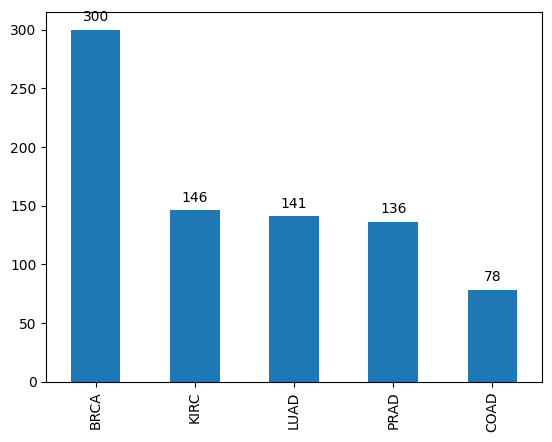

In [46]:
# distribution of tumor types
# label numbers on each bar
class_counts = labels['Class'].value_counts()

ax = class_counts.plot.bar()


for i, v in enumerate(class_counts):
    ax.text(i, v + 5, str(v), ha='center', va='bottom')

plt.show()


In [47]:
num_rows, num_columns = labels.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 801
Number of columns: 2


2. Data splitting and exploration

In [48]:
#########################
# label encoding and Data splitting #
#########################
X = data.iloc[:,1:]
Y = labels['Class']

# encoding tumor type Y into numbers
label_encoder = LabelEncoder()
# label_encoder.fit(Y)
Y_encoded = label_encoder.fit_transform(Y)

label = label_encoder.classes_
classes = np.unique(Y_encoded)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.25, random_state=42)

In [49]:
label

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [50]:
classes

array([0, 1, 2, 3, 4])

In [51]:
#########################
# Normalization of the gene expression data #
#########################
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled[:5, :]


array([[-0.18406868, -1.23712231,  0.73418729, ...,  0.17338772,
        -0.13803726, -0.26637402],
       [-0.18406868, -0.42473742, -0.17581678, ..., -1.1401484 ,
         0.35085364, -0.26637402],
       [-0.18406868,  0.70284916,  1.25846957, ..., -0.47264119,
         1.7377875 , -0.26637402],
       [-0.18406868,  0.6345826 ,  0.15148431, ..., -0.93749751,
         1.47602873,  0.94108278],
       [-0.18406868,  0.41845085, -0.04519272, ..., -0.24850087,
        -0.56767287, -0.26637402]])

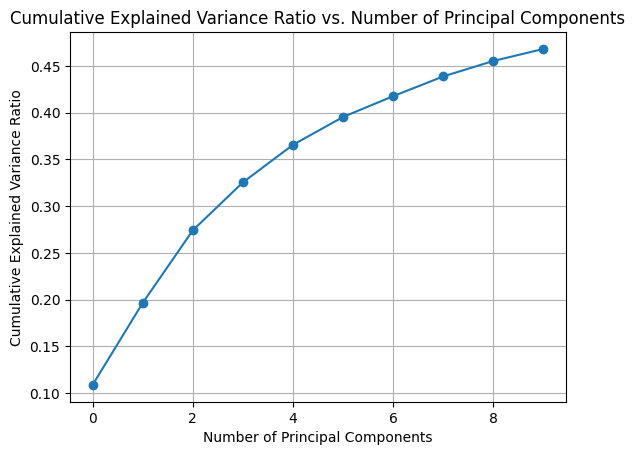

In [52]:
# PCA study
pca = PCA(n_components=10)
data_pca = pca.fit_transform(X_train_scaled)
# Cumulative Explained Variance Ratio
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance_ratio_cumsum, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

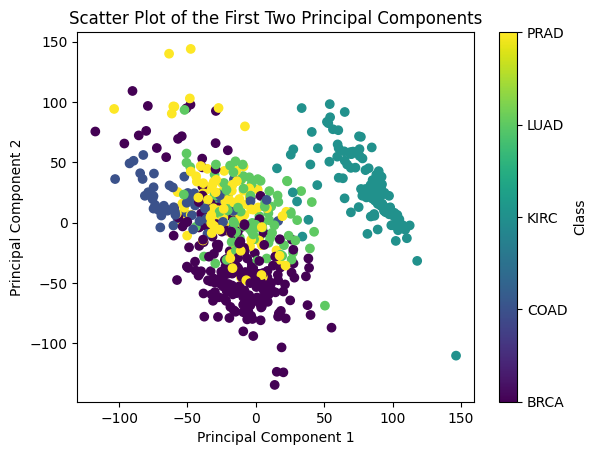

In [53]:
# dotplot of first 2 components
pca_components = data_pca[:, :2]

scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=Y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of the First Two Principal Components')

colorbar = plt.colorbar(scatter)
colorbar.set_ticks(range(len(label_encoder.classes_)))
colorbar.set_ticklabels(label_encoder.classes_)
colorbar.set_label('Class')

plt.show()

3. Models(Random Forest, XGBoost and linear SVM) on Random Forest features selection

In [54]:
#########################
# Feature selection using random forest #
#########################
# rf = RandomForestClassifier(n_estimators=20, random_state=42)
# rf = RandomForestClassifier(n_estimators=5, random_state=42)
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train_scaled, Y_train)

# Feature selection using SelectFromModel
sfm = SelectFromModel(rf, threshold='mean')
sfm.fit(X_train_scaled, Y_train)

# Get selected features
selected_features = sfm.get_support(indices=True)

# Train using selected features
X_train_selected = X_train_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]

num_selected_features = X_train_selected.shape[1]
test_selected_features = X_test_selected.shape[1]

print(f"Number of selected features: {num_selected_features}")
print(f"Number of test selected features: {test_selected_features}")




Number of selected features: 193
Number of test selected features: 193


Best parameters: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 10}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1score: 1.0


classification report


              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        80
        COAD       1.00      1.00      1.00        21
        KIRC       1.00      1.00      1.00        31
        LUAD       1.00      1.00      1.00        35
        PRAD       1.00      1.00      1.00        34

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201



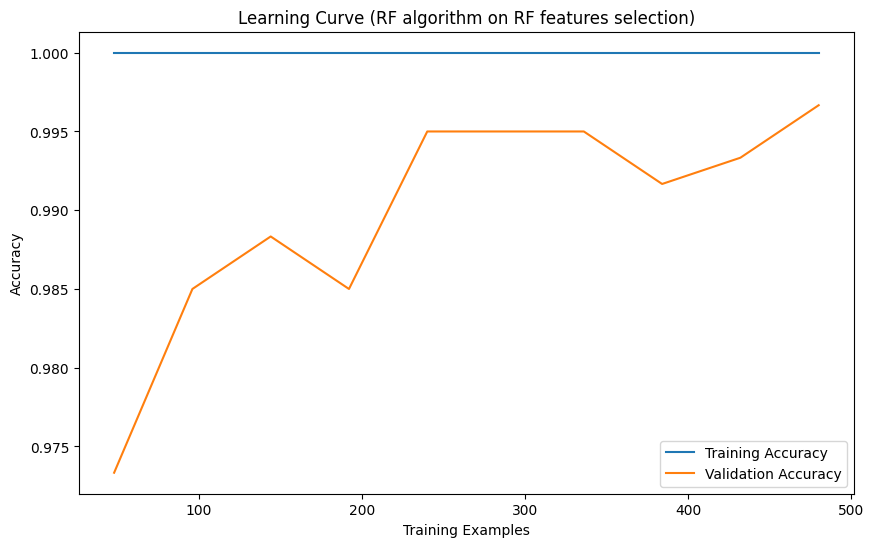

In [55]:
#########################
# RF algorithm on RF features selection (take about 2min) #
#########################
# Wrap random forest classifier in OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
# Set parameter search range
param_grid = {
    'estimator__n_estimators': [5, 10, 25, 50],
    'estimator__max_depth': [5, 10],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5]
}
# Search parameters using GridSearchCV
grid_search = GridSearchCV(ovr_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1) # n_jobs：Parallelization
grid_search.fit(X_train_selected, Y_train)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)

# Use the model with the best parameters to make predictions
best_classifier = grid_search.best_estimator_
Y_pred = best_classifier.predict(X_test_selected)

# accuracy
accuracy = accuracy_score(Y_test, Y_pred)
# precision
precision = np.round(precision_score(Y_test, Y_pred, average = 'weighted'),4)
# recall
recall = np.round(recall_score(Y_test, Y_pred, average = 'weighted'),4)
# F1 score
F1score = np.round(f1_score(Y_test, Y_pred, average = 'weighted'),4)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1score: {F1score}")

# classification report
report = classification_report(Y_test, Y_pred, target_names=label)
print('\n')
print('classification report\n\n')
print(report)

# learning curve
train_sizes, train_scores, test_scores = learning_curve(best_classifier, X_train_selected, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (RF algorithm on RF features selection)')
plt.legend()
plt.show()


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.8}
Accuracy: 0.995
Precision: 0.9952
Recall: 0.995
F1score: 0.995


classification report


              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        80
        COAD       1.00      0.95      0.98        21
        KIRC       1.00      1.00      1.00        31
        LUAD       0.97      1.00      0.99        35
        PRAD       1.00      1.00      1.00        34

    accuracy                           1.00       201
   macro avg       0.99      0.99      0.99       201
weighted avg       1.00      1.00      0.99       201



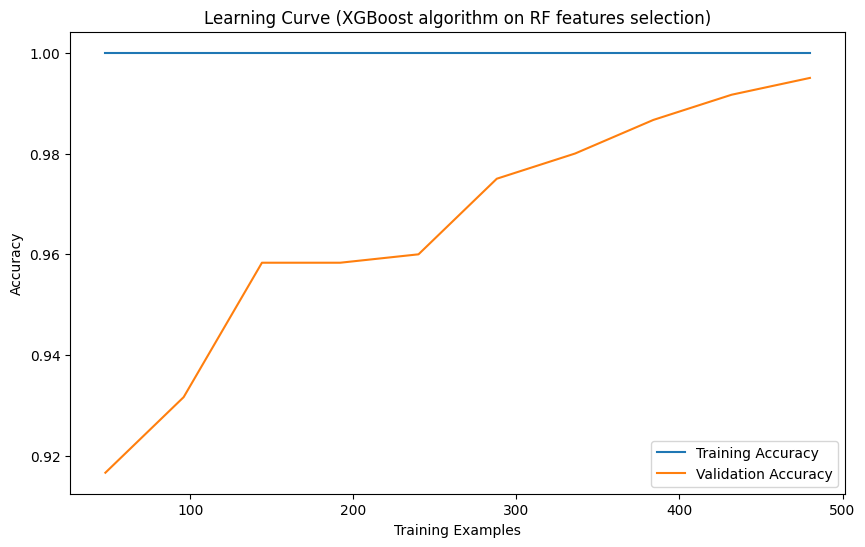

In [56]:
#########################
# XGBoost on RF features selection (Time: about 2mins46s) #
#########################
# built XGBoost classifier
xgb_classifier = XGBClassifier(objective="multi:softmax", num_class=5, n_jobs=-1)

# Setting up the XGBoost parameter grid
param_grid = {
    'n_estimators': [5, 10, 25],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],

}

# Search parameters using GridSearchCV
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, Y_train)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)

# Prediction using XGBoost model with optimal parameters
best_xgb_classifier = grid_search.best_estimator_
Y_pred_XGBoost = best_xgb_classifier.predict(X_test_selected)

# accuracy
accuracy = np.round(accuracy_score(Y_test, Y_pred_XGBoost),4)

# precision
precision = np.round(precision_score(Y_test, Y_pred_XGBoost, average = 'weighted'),4)
# recall
recall = np.round(recall_score(Y_test, Y_pred_XGBoost, average = 'weighted'),4)
# F1 score
F1score = np.round(f1_score(Y_test, Y_pred_XGBoost, average = 'weighted'),4)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1score: {F1score}")

# classification report
report = classification_report(Y_test, Y_pred_XGBoost, target_names=label)
print('\n')
print('classification report\n\n')
print(report)
# learning curve
train_sizes, train_scores, test_scores = learning_curve(best_xgb_classifier, X_train_selected, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (XGBoost algorithm on RF features selection)')
plt.legend()
plt.show()


Best parameters RF: {'C': 0.1, 'gamma': 'scale'}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1score: 1.0


classification report


              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        80
        COAD       1.00      1.00      1.00        21
        KIRC       1.00      1.00      1.00        31
        LUAD       1.00      1.00      1.00        35
        PRAD       1.00      1.00      1.00        34

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201



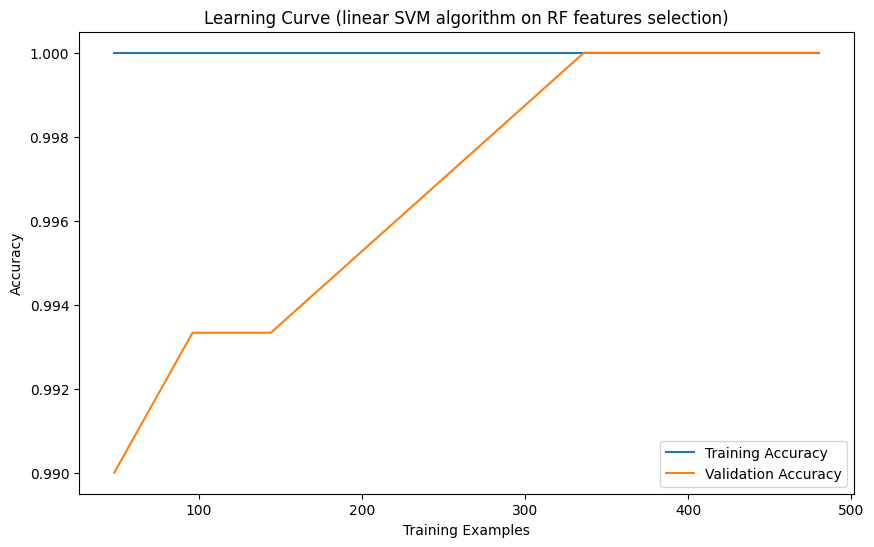

In [57]:
#########################
# Linear SVM algorithm on RF selection (Time: 2s) #
#########################
# Create SVM model
svm_classifier_rf = SVC(kernel='linear', decision_function_shape='ovr')

# Parameters setting
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
}

# Search parameters using GridSearchCV
grid_search_rf = GridSearchCV(svm_classifier_rf, param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_selected, Y_train)

# Get the optimal parameters
print("Best parameters RF:", grid_search_rf.best_params_)

# Prediction with optimal parameters
best_svm_rf = grid_search_rf.best_estimator_
y_pred_rf = best_svm_rf.predict(X_test_selected)

# accuracy
accuracy = accuracy_score(Y_test, y_pred_rf)
# precision
precision = np.round(precision_score(Y_test, y_pred_rf, average = 'weighted'),4)
# recall
recall = np.round(recall_score(Y_test, y_pred_rf, average = 'weighted'),4)
# F1 score
F1score = np.round(f1_score(Y_test, y_pred_rf, average = 'weighted'),4)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1score: {F1score}")

# classification report
report = classification_report(Y_test, y_pred_rf, target_names=label)
print('\n')
print('classification report\n\n')
print(report)

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(best_svm_rf, X_train_selected, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (linear SVM algorithm on RF features selection)')
plt.legend()
plt.show()



In [58]:
#########################
# Neural Network on RF selection  (Time: 1min) #
#########################
# transfer data to PyTorch tensor
X_train_tensor = torch.Tensor(X_train_selected)
Y_train_tensor = torch.LongTensor(Y_train)

# define NN model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

# define train model
def train_model(model, criterion, optimizer, dataloader):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# define cross validation function
def cross_validation(model, X, Y, hidden_size, lr, num_epochs=50, batch_size=32):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    best_models = []

    for train_index, val_index in kfold.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        Y_train_fold, Y_val_fold = Y[train_index], Y[val_index]

        train_dataset = TensorDataset(torch.Tensor(X_train_fold), torch.LongTensor(Y_train_fold))
        val_dataset = TensorDataset(torch.Tensor(X_val_fold), torch.LongTensor(Y_val_fold))

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = NeuralNetwork(input_size=X.shape[1], hidden_size=hidden_size, output_size=5)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            train_loss = train_model(model, criterion, optimizer, train_dataloader)

        # Evaluate on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        accuracies.append(accuracy)
        best_models.append(model)

    return sum(accuracies) / len(accuracies), best_models

# define parameters range
param_grid = {
    'hidden_size': [10, 20, 30],
    'lr': [0.01, 0.001, 0.0001]
}

# search in parameters
best_accuracy = 0.0
best_params = {}

for hidden_size in param_grid['hidden_size']:
    for lr in param_grid['lr']:
        accuracy, _ = cross_validation(NeuralNetwork, X_train_tensor, Y_train_tensor, hidden_size, lr)
        print(f"Hidden Size: {hidden_size}, Learning Rate: {lr}, Accuracy: {accuracy}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'hidden_size': hidden_size, 'lr': lr}

print("Best parameters:", best_params)


Hidden Size: 10, Learning Rate: 0.01, Accuracy: 0.9983333333333334
Hidden Size: 10, Learning Rate: 0.001, Accuracy: 1.0
Hidden Size: 10, Learning Rate: 0.0001, Accuracy: 0.9483333333333335
Hidden Size: 20, Learning Rate: 0.01, Accuracy: 0.9983333333333334
Hidden Size: 20, Learning Rate: 0.001, Accuracy: 1.0
Hidden Size: 20, Learning Rate: 0.0001, Accuracy: 0.9933333333333334
Hidden Size: 30, Learning Rate: 0.01, Accuracy: 0.9983333333333334
Hidden Size: 30, Learning Rate: 0.001, Accuracy: 0.9983333333333334
Hidden Size: 30, Learning Rate: 0.0001, Accuracy: 0.9966666666666667
Best parameters: {'hidden_size': 10, 'lr': 0.001}


In [59]:
# Use optimal parameters for training and validation
best_hidden_size = best_params['hidden_size']
best_lr = best_params['lr']
best_accuracy, best_models = cross_validation(NeuralNetwork, X_train_tensor, Y_train_tensor, best_hidden_size, best_lr)

# Make predictions on the test set
X_test_tensor = torch.Tensor(X_test_selected)
Y_test_tensor = torch.LongTensor(Y_test)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_predictions = []

for model in best_models:
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.numpy())
    all_predictions.append(predictions)

# Vote on all model predictions
ensemble_predictions = np.array(all_predictions).T
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=ensemble_predictions)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test, final_predictions)
precision = precision_score(Y_test, final_predictions, average='macro')
recall = recall_score(Y_test, final_predictions, average='macro')
f1 = f1_score(Y_test, final_predictions, average='macro')
classification_report_str = classification_report(Y_test, final_predictions)


print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)
print('Classification report:\n', classification_report_str)




Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00        34

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201



4. Models(Random Forest, XGBoost and linear SVM) on LDA features selection

In [60]:
#########################
# Linear Discriminant Analysis (LDA) features selection #
#########################
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_scaled, Y_train)
X_test_lda = lda.transform(X_test_scaled)

print("Original number of features:", X_train.shape[1])
print("Number of features after LDA:", X_train_lda.shape[1])

Original number of features: 20531
Number of features after LDA: 4


Best parameters: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1score: 1.0


classification report


              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        80
        COAD       1.00      1.00      1.00        21
        KIRC       1.00      1.00      1.00        31
        LUAD       1.00      1.00      1.00        35
        PRAD       1.00      1.00      1.00        34

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201



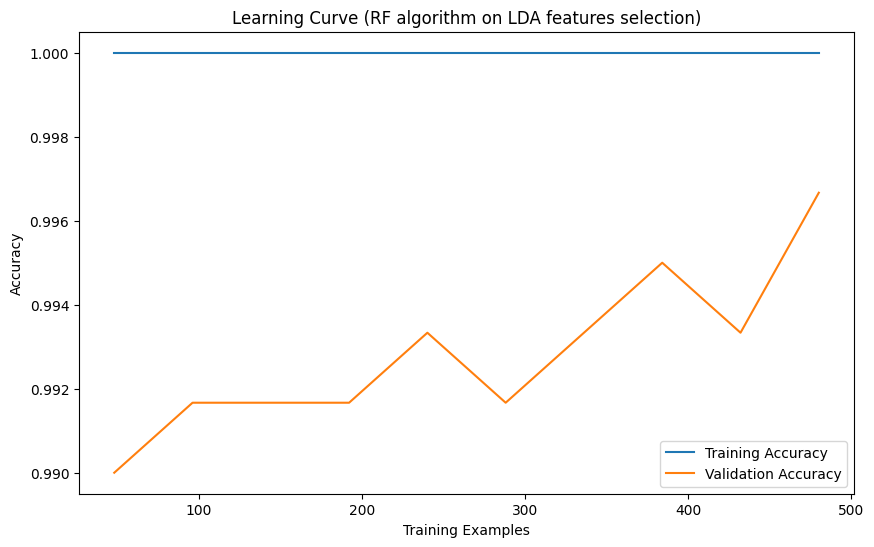

In [61]:
#########################
# RF on LDA features selection （Time: 1min ） #
#########################
# Wrap random forest classifier in OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
# Set parameter search range
param_grid = {
    'estimator__n_estimators': [5, 10, 25, 50],
    'estimator__max_depth': [5, 10],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5]
}
# Search parameters using GridSearchCV
grid_search = GridSearchCV(ovr_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1) # n_jobs：Parallelization
grid_search.fit(X_train_lda, Y_train)


# Use the model with the best parameters to make predictions
best_classifier = grid_search.best_estimator_
Y_pred = best_classifier.predict(X_test_lda)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)


# accuracy
accuracy = accuracy_score(Y_test, Y_pred)
# precision
precision = np.round(precision_score(Y_test, Y_pred, average = 'weighted'),4)
# recall
recall = np.round(recall_score(Y_test, Y_pred, average = 'weighted'),4)
# F1 score
F1score = np.round(f1_score(Y_test, Y_pred, average = 'weighted'),4)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1score: {F1score}")

# classification report
report = classification_report(Y_test, Y_pred, target_names=label)
print('\n')
print('classification report\n\n')
print(report)

# learning curve
train_sizes, train_scores, test_scores = learning_curve(best_classifier, X_train_lda, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (RF algorithm on LDA features selection)')
plt.legend()
plt.show()

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1score: 1.0


classification report


              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        80
        COAD       1.00      1.00      1.00        21
        KIRC       1.00      1.00      1.00        31
        LUAD       1.00      1.00      1.00        35
        PRAD       1.00      1.00      1.00        34

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201



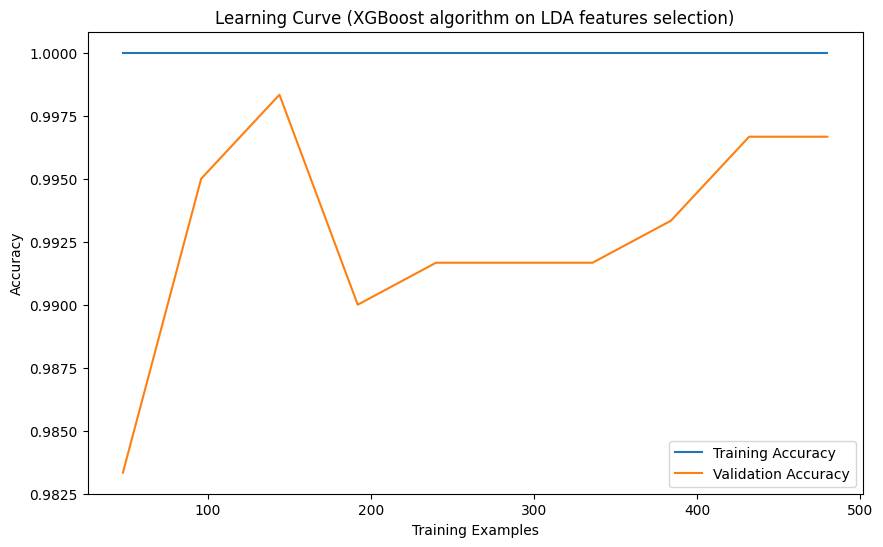

In [62]:
#########################
# XGBoost on LDA （Time: 17s but n_estimators = 100） #
#########################
# built XGBoost classifier
xgb_classifier = XGBClassifier(objective="multi:softmax", num_class=5, n_jobs=-1)

# Setting up the XGBoost parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Search parameters using GridSearchCV
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_lda, Y_train)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)

# Prediction using XGBoost model with optimal parameters
best_xgb_classifier = grid_search.best_estimator_
Y_pred_XGBoost = best_xgb_classifier.predict(X_test_lda)

# accuracy
accuracy = np.round(accuracy_score(Y_test, Y_pred_XGBoost),4)

# precision
precision = np.round(precision_score(Y_test, Y_pred_XGBoost, average = 'weighted'),4)
# recall
recall = np.round(recall_score(Y_test, Y_pred_XGBoost, average = 'weighted'),4)
# F1 score
F1score = np.round(f1_score(Y_test, Y_pred_XGBoost, average = 'weighted'),4)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1score: {F1score}")

# classification report
report = classification_report(Y_test, Y_pred_XGBoost, target_names=label)
print('\n')
print('classification report\n\n')
print(report)
# learning curve
train_sizes, train_scores, test_scores = learning_curve(best_xgb_classifier, X_train_lda, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (XGBoost algorithm on LDA features selection)')
plt.legend()
plt.show()


Best parameters LDA: {'C': 0.1, 'gamma': 'scale'}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1score: 1.0


classification report


              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        80
        COAD       1.00      1.00      1.00        21
        KIRC       1.00      1.00      1.00        31
        LUAD       1.00      1.00      1.00        35
        PRAD       1.00      1.00      1.00        34

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201



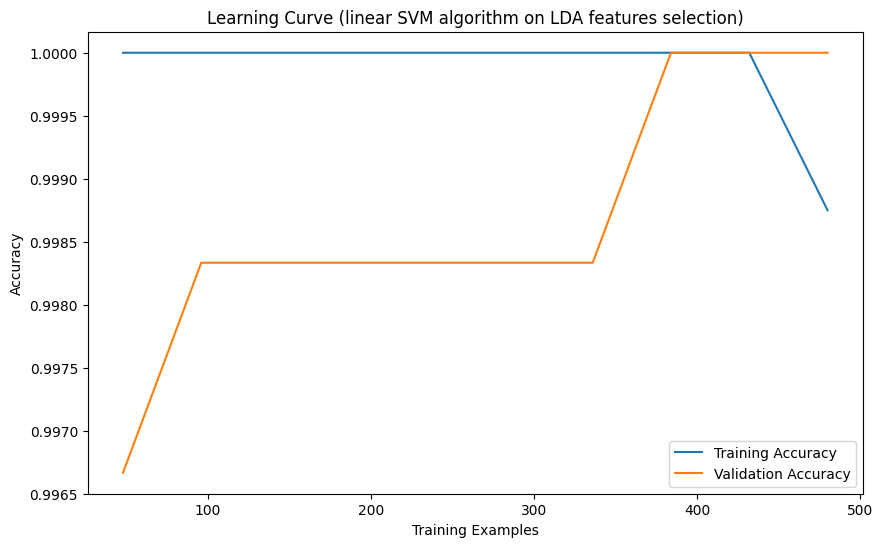

In [63]:
#########################
# Linear SVM algorithm on LDA features selection (Time: fast) #
#########################
# Create SVM model
svm_classifier_lda = SVC(kernel='linear', decision_function_shape='ovr')

# Parameters setting
param_grid = {
    'C': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
}

# Parameters searching using GridSearchCV
grid_search_lda = GridSearchCV(svm_classifier_lda, param_grid, cv=5, scoring='accuracy')
grid_search_lda.fit(X_train_lda, Y_train)

# Get the optimal parameters
print("Best parameters LDA:", grid_search_lda.best_params_)

# Prediction with optimal parameters
best_svm_lda = grid_search_lda.best_estimator_
y_pred_lda = best_svm_lda.predict(X_test_lda)

# accuracy
accuracy = accuracy_score(Y_test, y_pred_lda)
# precision
precision = np.round(precision_score(Y_test, y_pred_lda, average = 'weighted'),4)
# recall
recall = np.round(recall_score(Y_test, y_pred_lda, average = 'weighted'),4)
# F1 score
F1score = np.round(f1_score(Y_test, y_pred_lda, average = 'weighted'),4)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1score: {F1score}")

# classification report
report = classification_report(Y_test, y_pred_lda, target_names=label)
print('\n')
print('classification report\n\n')
print(report)

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(best_svm_lda, X_train_lda, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (linear SVM algorithm on LDA features selection)')
plt.legend()
plt.show()


In [64]:
#########################
# Neural Network on LDA selection (Time: 1min) #
#########################
# transfer data to PyTorch tensor
X_train_tensor = torch.Tensor(X_train_lda)  # Change here
Y_train_tensor = torch.LongTensor(Y_train)

# define NN model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

# define train model
def train_model(model, criterion, optimizer, dataloader):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# define cross validation function
def cross_validation(model, X, Y, hidden_size, lr, num_epochs=50, batch_size=32):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    best_models = []

    for train_index, val_index in kfold.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        Y_train_fold, Y_val_fold = Y[train_index], Y[val_index]

        train_dataset = TensorDataset(torch.Tensor(X_train_fold), torch.LongTensor(Y_train_fold))
        val_dataset = TensorDataset(torch.Tensor(X_val_fold), torch.LongTensor(Y_val_fold))

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = NeuralNetwork(input_size=X.shape[1], hidden_size=hidden_size, output_size=5)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            train_loss = train_model(model, criterion, optimizer, train_dataloader)

        # Evaluate on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        accuracies.append(accuracy)
        best_models.append(model)

    return sum(accuracies) / len(accuracies), best_models

# define parameters range
param_grid = {
    'hidden_size': [10, 20, 30],
    'lr': [0.01, 0.001, 0.0001]
}

# search in parameters
best_accuracy = 0.0
best_params = {}

for hidden_size in param_grid['hidden_size']:
    for lr in param_grid['lr']:
        accuracy, _ = cross_validation(NeuralNetwork, X_train_tensor, Y_train_tensor, hidden_size, lr)
        print(f"Hidden Size: {hidden_size}, Learning Rate: {lr}, Accuracy: {accuracy}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'hidden_size': hidden_size, 'lr': lr}

print("Best parameters:", best_params)

# Use optimal parameters for training and validation
best_hidden_size = best_params['hidden_size']
best_lr = best_params['lr']
best_accuracy, best_models = cross_validation(NeuralNetwork, X_train_tensor, Y_train_tensor, best_hidden_size, best_lr)

# Make predictions on the test set
X_test_tensor = torch.Tensor(X_test_lda)  # Change here
Y_test_tensor = torch.LongTensor(Y_test)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_predictions = []

for model in best_models:
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.numpy())
    all_predictions.append(predictions)

# Vote on all model predictions
ensemble_predictions = np.array(all_predictions).T
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=ensemble_predictions)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test, final_predictions)
precision = precision_score(Y_test, final_predictions, average='macro')
recall = recall_score(Y_test, final_predictions, average='macro')
f1 = f1_score(Y_test, final_predictions, average='macro')
classification_report_str = classification_report(Y_test, final_predictions)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)
print('Classification report:\n', classification_report_str)


Hidden Size: 10, Learning Rate: 0.01, Accuracy: 0.9983333333333334
Hidden Size: 10, Learning Rate: 0.001, Accuracy: 1.0
Hidden Size: 10, Learning Rate: 0.0001, Accuracy: 0.5916666666666666
Hidden Size: 20, Learning Rate: 0.01, Accuracy: 0.9966666666666667
Hidden Size: 20, Learning Rate: 0.001, Accuracy: 1.0
Hidden Size: 20, Learning Rate: 0.0001, Accuracy: 0.9233333333333335
Hidden Size: 30, Learning Rate: 0.01, Accuracy: 0.9966666666666667
Hidden Size: 30, Learning Rate: 0.001, Accuracy: 0.9983333333333334
Hidden Size: 30, Learning Rate: 0.0001, Accuracy: 0.9616666666666667
Best parameters: {'hidden_size': 10, 'lr': 0.001}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        35
           4      